<a href="https://colab.research.google.com/github/geniusserg/DataAnalyzis/blob/main/PyTorch_musicClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -r https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/audio-pytorch/install-packages.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [62]:
import os
import torchaudio
import torch
import IPython.display as ipd
import matplotlib.pyplot as plt

Load data with some words

In [41]:
DATA_DIR = "data"
if not os.path.exists(DATA_DIR):
  os.mkdir(DATA_DIR)
  trainset_speechcommands = torchaudio.datasets.SPEECHCOMMANDS(f'./{DATA_DIR}/', download=True)
cdir = os.getcwd()
os.chdir(f"./{DATA_DIR}/SpeechCommands/speech_commands_v0.02/")
labels = [dir for dir in os.listdir(".") if os.path.isdir(dir)]
print("Labels: "," ".join(labels))
print("Count: ", len(labels))
os.chdir(cdir)

Labels:  happy no cat down up go yes marvin eight zero on house right three six five dog bird sheila learn follow left wow four bed off stop forward visual tree seven one _background_noise_ backward two nine
Count:  36


Visualize waveform of sample "YES" wav

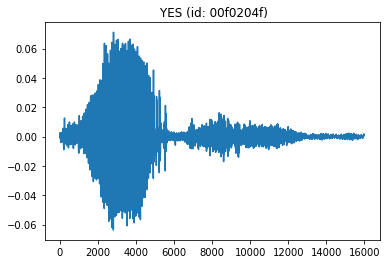

In [44]:
filename = f"./{DATA_DIR}/SpeechCommands/speech_commands_v0.02/yes/00f0204f_nohash_0.wav"
def plot_waveform(filename):
  num = filename.split("/")[-1].split("_")[0]
  lab = filename.split("/")[-2].upper()
  waveform, bitrate = torchaudio.load(filename)
  plt.plot(waveform.t().numpy())
  plt.title(f" {lab} (id: {num})")
  ipd.Audio(waveform.numpy(), rate=bitrate)
plot_waveform(filename)

Create dataLoaders with Yes and No audies

In [69]:
def load_data(dir_path:str, label:str):
  dir_path = os.path.join(dir_path, label)
  assert os.path.exists(dir_path)
  data_list = []
  for idx, filename in enumerate(os.listdir(dir_path)):
    waveform, bitrate = torchaudio.load(os.path.join(dir_path, filename))
    speech_id, _ = filename.split("_nohash_")
    utterance, _ = _.split(".")
    if (_ != "wav"):
      continue
    data_list.append([waveform, bitrate, label, speech_id, utterance])
  print(dir_path, "Processed")
  return data_list

data_yes = load_data(f"./{DATA_DIR}/SpeechCommands/speech_commands_v0.02", label="yes")
train_yes_dataloader = torch.utils.data.DataLoader(data_yes, batch_size=1)
data_no = load_data(f"./{DATA_DIR}/SpeechCommands/speech_commands_v0.02", label="no")
train_no_dataloader = torch.utils.data.DataLoader(data_no, batch_size=1)

./data/SpeechCommands/speech_commands_v0.02/yes Processed
./data/SpeechCommands/speech_commands_v0.02/no Processed


## WaveForms

YES

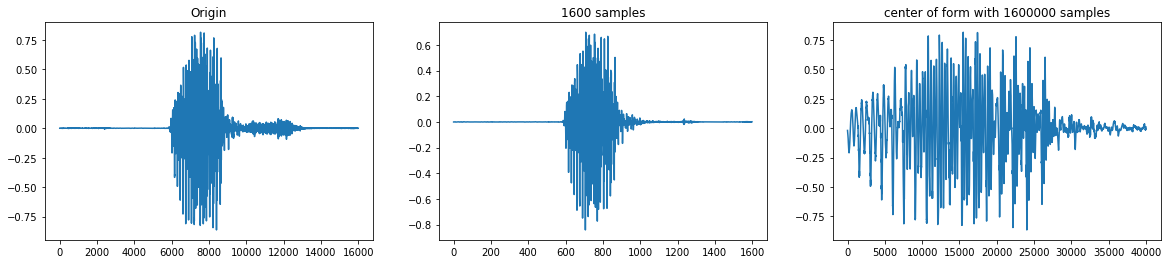

In [89]:
def resample(waveform, bitrate, scale = 0.1):
  new_waveform = torchaudio.transforms.Resample(bitrate, bitrate*scale)(waveform[0,:].view(1,-1))
  return new_waveform 

waveform_yes_sample = data_yes[0][0]
new_waveform_yes_sample = resample(waveform_yes_sample, 16000, 0.1)
hard_waveform_yes_sample = resample(waveform_yes_sample, 16000, 10)

figure, ax = plt.subplots(1, 3)
figure.set_figwidth(20)
ax[0].plot(waveform_yes_sample[0,:].numpy())
ax[1].plot(new_waveform_yes_sample[0,:].numpy())
ax[2].plot(hard_waveform_yes_sample[0,60000:100000].numpy())
ax[0].title.set_text("Origin 16000 samples")
ax[1].title.set_text("1600 samples")
ax[2].title.set_text("center of form with 1600000 samples")
plt.show()

NO

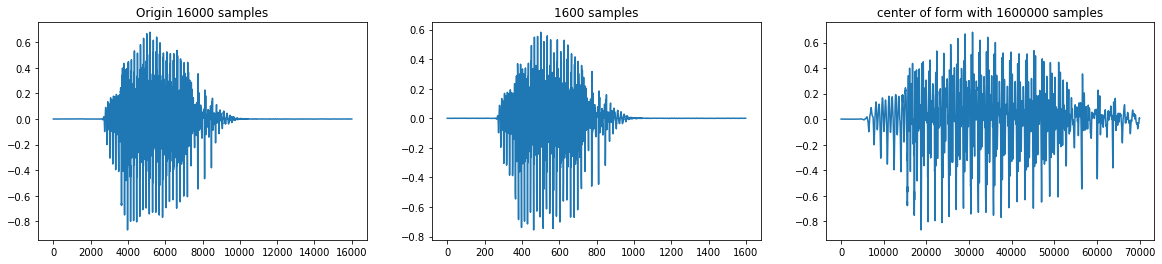

In [93]:
waveform_no_sample = data_no[0][0]
new_waveform_no_sample = resample(waveform_no_sample, 16000, 0.1)
hard_waveform_no_sample = resample(waveform_no_sample, 16000, 10)

figure, ax = plt.subplots(1, 3)
figure.set_figwidth(20)
ax[0].plot(waveform_no_sample[0,:].numpy())
ax[1].plot(new_waveform_no_sample[0,:].numpy())
ax[2].plot(hard_waveform_no_sample[0,21000:91000].numpy())
ax[0].title.set_text("Origin 16000 samples")
ax[1].title.set_text("1600 samples")
ax[2].title.set_text("center of form with 1600000 samples")
plt.show()

## Spectrogram

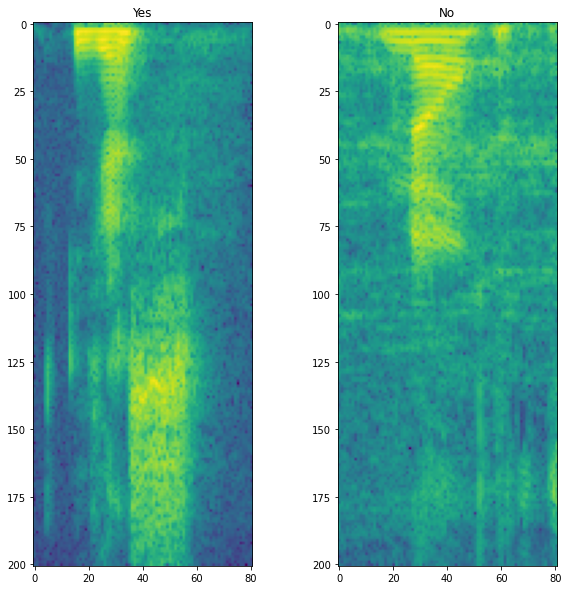

In [123]:
waveform_yes_sample = data_yes[123][0]
spectrogram_yes_sample = torchaudio.transforms.Spectrogram()(waveform_yes_sample)

waveform_no_sample = data_no[123][0]
spectrogram_no_sample = torchaudio.transforms.Spectrogram()(waveform_no_sample)

plt.figure(figsize=[10, 10])
plt.subplot(121)
plt.title("Yes")
plt.imshow(spectrogram_yes_sample.log2()[0, ...].numpy(), cmap='viridis')
plt.subplot(122)
plt.title("No")
plt.imshow(spectrogram_no_sample.log2()[0, ...].numpy(), cmap='viridis')
plt.show()

Mel Spectrogram

/usr/local/lib/python3.8/dist-packages/torchaudio/functional/functional.py:571: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


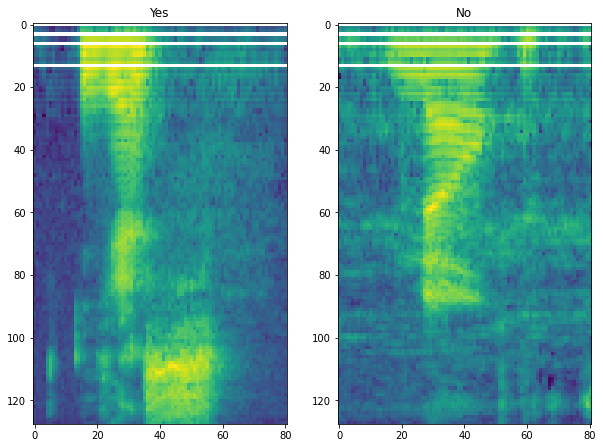

In [124]:
waveform_yes_sample = data_yes[123][0]
spectrogram_yes_sample = torchaudio.transforms.MelSpectrogram()(waveform_yes_sample)

waveform_no_sample = data_no[123][0]
spectrogram_no_sample = torchaudio.transforms.MelSpectrogram()(waveform_no_sample)

plt.figure(figsize=[10, 10])
plt.subplot(121)
plt.title("Yes")
plt.imshow(spectrogram_yes_sample.log2()[0, ...].numpy(), cmap='viridis')
plt.subplot(122)
plt.title("No")
plt.imshow(spectrogram_no_sample.log2()[0, ...].numpy(), cmap='viridis')
plt.show()

MFCC

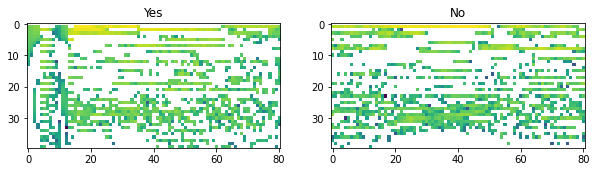

In [127]:
waveform_yes_sample = data_yes[123][0]
spectrogram_yes_sample = torchaudio.transforms.MFCC(16000)(waveform_yes_sample)

waveform_no_sample = data_no[123][0]
spectrogram_no_sample = torchaudio.transforms.MFCC(16000)(waveform_no_sample)

plt.figure(figsize=[10, 10])
plt.subplot(121)
plt.title("Yes")
plt.imshow(spectrogram_yes_sample.log2()[0, ...].numpy(), cmap='viridis')
plt.subplot(122)
plt.title("No")
plt.imshow(spectrogram_no_sample.log2()[0, ...].numpy(), cmap='viridis')
plt.show()

Save spectrograms


In [ ]:
%%script false
os.mkdir("images")
os.mkdir("images/spec")
os.mkdir("images/spec/yes")
os.mkdir("images/spec/no")
os.mkdir("images/mel")
os.mkdir("images/mel/yes")
os.mkdir("images/mel/no")
os.mkdir("images/mfcc")
os.mkdir("images/mfcc/yes")
os.mkdir("images/mfcc/no")


In [ ]:
from tqdm import tqdm
def save_pic(data, label, typed, generator):
  for idx, waveform in tqdm(data):
    spectrogram = generator(waveform[0])
    plt.figure()
    fig = plt.gcf()
    plt.imshow(spectrogram.log2()[0].numpy(), cmap='viridis')
    plt.draw()
    fig.savefig(f"./images/{typed}/{label}/{typed}_{idx}.png", dpi=100)

save_pic(data_yes, "yes", "spec", torchaudio.transforms.Spectrogram())
save_pic(data_yes, "no", "spec", torchaudio.transforms.Spectrogram())
save_pic(data_yes, "yes", "mel", torchaudio.transforms.MelSpectrogram())
save_pic(data_yes, "no", "mel", torchaudio.transforms.MelSpectrogram())
save_pic(data_yes, "yes", "mfcc", torchaudio.transforms.MFCC())
save_pic(data_yes, "no", "mfcc", torchaudio.transforms.MFCC())

<ipython-input-142-ccd04ae98013>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


# Build computer vision models for spectrogram classfifcation

In [134]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
from torchsummary import summary
import pandas as pd
import os